In [1]:
from __future__ import print_function
from fenics import *
from ufl import nabla_div
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

## $\frac{\partial N}{\partial t} + \frac{\partial c_x N}{\partial x} + \frac{\partial c_y N}{\partial y} +  \frac{\partial c_\sigma N}{\partial \sigma}+ \frac{\partial c_\theta N}{\partial \theta}  = \frac{S(\sigma, \theta, t)}{\sigma}$



## Uniform coastline:

Assuming coast line that varies along x direction but is uniform in y, mathematically meaning:

$\frac{\partial N}{\partial y} = 0$ and $\frac{\partial c_{y}}{\partial y} = 0$

likewise in $\theta$

$\frac{\partial N}{\partial \theta} = 0$ and $\frac{\partial c_{\theta}}{\partial \theta} = 0$

Which makes action balance equation:

$\frac{\partial N}{\partial t} + \frac{\partial c_x N}{\partial x} + \frac{\partial c_\sigma N}{\partial \sigma}+  = \frac{S(x, \sigma, t)}{\sigma}$

In this specific script we will perform the test as seen in ONR test bed case A21

## Case A21

"An infinitely long plane beach with parallel depth contours (slope 1:200) is considered. The x-axis is normal to the depth contours (see Figure 7). At a water depth of 20m, monochromatic, uni- directional waves enter the model area. At the up-wave boundary the incoming waves propagate at an angle of 0° relative to the positive x-axis. The distance of the up-wave boundary to the waterline is 4000 m. The incident wave height Hi and period Ti are 1 m and 10 s respectively.
Ambient currents and wind are absent."

## Conditions
In the SWAN computation this harmonic wave is simulated with a Gaussian-shaped frequency spectrum with peak
frequency 0.1 Hz, standard deviation 0.01 Hz, and a resolution
of 3% of the frequency (diffusion in frequency space does not
occur as $c_{\sigma}$= 0 in this case, and the frequency resolution may
therefore be somewhat coarse). The long crestedness in this
computation is simulated with a $cos^{500} (\theta)$ directional distribution (the directional width $\sigma_{\theta} = 2.5 $ degrees, where su is the standard
deviation of the directional distribution



## Solution

$\frac{H^2}{H_i^2}=\frac{c_{g,i}cos(\theta_i)}{c_g cos(\theta)}$

Where $H_i$ , $c_{g,i}$, $\theta_i$ is the boundary condition that remains steady through time

In [2]:
#all functions necessary to run Test Case 4
#this expression requires sigma to be in second index
def Gauss_Expression_1D(F_peak,F_std,HS):
    aux1 = aux1 = HS**2/(16*np.sqrt(2*np.pi)*F_std)
    aux3 = 2*F_std**2
    #CTOT = np.sqrt(0.5*500/np.pi)/(1-0.25/500)
    E=Expression('aux1*exp(-pow(x[1]-2*pi*F_peak,2)/aux3)',
                degree=4,aux1=aux1,aux3=aux3,F_peak=F_peak)
    return E

def Gauss_Expression_IC(F_peak,F_std,HS):
    aux1 = aux1 = HS**2/(16*np.sqrt(2*np.pi)*F_std)
    aux3 = 2*F_std**2
    tol=1e-14
    #CTOT = np.sqrt(0.5*500/np.pi)/(1-0.25/500)
    E=Expression('x[0] < tol ? aux1*exp(-pow(x[1]-2*pi*F_peak,2)/aux3): 0',
                degree=4,aux1=aux1,aux3=aux3,F_peak=F_peak,tol=tol,t=0)
    return E

def Gauss_IC(F_peak,F_std,HS,x,sigmas):
    #takes in dof and paramters
    #returns vector with initial condition values at global DOF
    aux1 = HS**2/(16*np.sqrt(2*np.pi)*F_std)
    aux3 = 2*F_std**2
    tol=1e-14
    E = (x<tol)*aux1*np.exp(-(sigmas - 2*np.pi*F_peak)**2/aux3)
    return E


#an Expression class to evaluate u(x,y) on the 1D domain (range y, x fixed)
#maybe modify so input can determine if we want range y (fixed x) or range x (fixed y)
#this case want space to be x, sigma to be y
class my1DExpression(UserExpression):
    def __init__(self,u_2d,x,**kwargs):
        super().__init__(**kwargs)
        self.u_2d=u_2d
        self.x=x
        #Expression.__init__(self)
        self._vx= np.array([0.])
        self._pt_x= np.array([0.,0.])
    def eval(self, values, x):
        self._pt_x[0]= self.x
        self._pt_x[1]= x[0]
        self.u_2d.eval(self._vx,self._pt_x)
        values[0] = self._vx[0]
        
#need a function to calculate wave speed (phase and group) and wavenumber
def swan_calc_wavespeeds_k(sigmas,depths,g=9.81):
    #taken from Jessica's code
    cg_out=np.zeros(len(sigmas))
    k_out=np.zeros(len(sigmas))
    WGD=np.sqrt(depths/g)*g
    SND=sigmas*np.sqrt(depths/g)
    
    shallow_range=np.argwhere(SND<1e-6)
    mid_range=np.argwhere((SND<2.5)&(SND>=1e-6))
    deep_range=np.argwhere(SND>=2.5)
    
    def cg_mid(SND,g,depths,sigmas):
        SND2=SND*SND
        C=np.sqrt(g*depths/(SND2 +1/(1+0.666*SND2+.445*SND2**2 
                                     - 0.105*SND2**3 + 0.272*SND2**4)))
        KND=sigmas*depths/C
        
        FAC1=2*KND/np.sinh(2*KND)
        N=0.5*(1+FAC1)
        return N*C,sigmas/C
    def cg_deep(g,sigmas):
        return 0.5*g/sigmas
    def cg_shallow(WGD):
        return WGD

    cg_out[shallow_range]=cg_shallow(WGD[shallow_range])
    k_out[shallow_range]=SND[shallow_range]/depths[shallow_range]
    cg_out[mid_range],k_out[mid_range]=cg_mid(SND[mid_range],g,depths[mid_range],sigmas[mid_range])
    cg_out[deep_range]=cg_deep(g,sigmas[deep_range])
    k_out[deep_range]=sigmas[deep_range]**2/g

    return cg_out,k_out

def calc_c_sigma(sigmas,k,depths,c_g,currents,z_coords,loc_num):
    ##Inputs
    #sigmas - takes in a vector of sigma values (sigma coordinate at each d.o.f) at one point in physical spaxe
    #thetas
    #k - wavenumber corresponding to the given sigmas and thetas
    #c_g - corresponding group velocity
    #(note sigmas, thetas,k,c_g should all be same length which is number of d.o.f in one 2D slice)
    #depths - depths in meters of ALL physical coordinates (not just current one)
    #z_coords - unique coordinates in physical space (not just current one)
    #currents - water velocity at ALL physical coordinates
    #loc_num - the number of the physical point (starts at 0)
    #(note depths,z_coords,currents should all be same length which is the number of unique points in physical space)
    ##Outputs
    #outputs a vector same size as sigmas that is the c_sigma at all d.o.f in ONE 2D slice 
    #of the 3D domain corresponding to a single point in physical space for c_theta and c_sigma
    
    #for now assuming H is constant in time but can fix this later
    dHdt=0.0
    dHdy = 0.0
    dudy = 0.0
    dvdx = 0.0 #migh not have to be 0, well see
    dvdy = 0.0
    
    #also going to assume v is zero but maybe can change this later
    v=0.0
    u=0.0#currents[loc_num]
    H=depths#[loc_num]
    #calc gradient of H w.r.t. x
    #this is just forward euler but only works for fixed geometry
    #instead we'll hard code for this case
    dHdx=-1.0/200.0
    dudx=0.0
    '''
    if loc_num == 0:
        dHdx =(depths[loc_num+1]-H)/(z_coords[loc_num+1]-z_coords[loc_num])
        dudx = (currents[loc_num+1]-u)/(z_coords[loc_num+1]-z_coords[loc_num])
    elif loc_num == len(z_coords)-1:
        dHdx = (H-depths[loc_num-1])/(z_coords[loc_num]-z_coords[loc_num-1])
        dudx = (u-currents[loc_num-1])/(z_coords[loc_num]-z_coords[loc_num-1])
    else:
        dHdx = (depths[loc_num+1]-depths[loc_num-1])/(z_coords[loc_num+1]-z_coords[loc_num-1])
        dudx = (currents[loc_num+1]-currents[loc_num-1])/(z_coords[loc_num+1]-z_coords[loc_num-1])
    '''
    
    #now calculate velocity vectors
    c_sigma = k*sigmas/(np.sinh(2*k*H)) *(dHdt + u*dHdx + v*dHdy) - c_g*k*(dudx)
    #c_theta = sigmas/(np.sinh(2*k*H))*(dHdx*np.sin(thetas)- dHdy*np.cos(thetas)) + \
    #    dudx*np.cos(thetas)*np.sin(thetas) - dudy*(np.cos(thetas)**2) + dvdx*(np.sin(thetas)**2) \
    #    -dvdy*np.cos(thetas)*np.sin(thetas)
    return c_sigma #,c_theta

###
###
###
#all functions relating to Cartesian product
def cartesian_product_dofs(array1,array2):
    #gives cartesian product of 2 1d vectors
    dim1=len(array1)
    dim2=len(array2)
    out_arr=np.zeros((dim1*dim2,2))
    c=0
    for a in range(dim1):
        for b in range(dim2):
            out_arr[c,:]=[array1[a],array2[b]]
            c=c+1
    return out_arr

def cartesian_product_coords(array1,array2):
    #gives cartesian product of 2 vectors
    dim1,n1=array1.shape
    dim2,n2=array2.shape
    out_arr=np.zeros((dim1*dim2,n1+n2))
    c=0
    for a in range(dim1):
        for b in range(dim2):
            #print(array1[a,:])
            #print(array2[b,:])
            out_arr[c,:]=np.append(array1[a,:],array2[b,:])
            c=c+1
    return out_arr

def cartesian_form_to_kroneck_form(indeces, len_dim_2):
    #designed to take list of indexes in the cartesian form
    #translate to single form as kron product would
    #only for cartesian product between 2 spaces
    #expects matrix with n rows, 2 columns
    num_indeces=indeces.shape[0]
    out_arr=np.zeros(num_indeces)
    for n in range(num_indeces):
        out_arr[n] = indeces[n,0]*len_dim_2 + indeces[n,1]
    return out_arr

def spec_mult(c,K):
    len_dof=len(c)
    for i in range(len_dof):
        for j in range(len_dof):
            K[i,j] = (c[i]+c[j])/2*K[i,j]
    return K

In [3]:
##model parameters/inputs

#first create mesh, mesh 1 is space, mesh 2 is sigma
omega_min=0 #smallest rad. frequency (needs to be larger than 0)
omega_max = 1.0 #largest rad. frequency
n_sigma = 20 #number of elements in frequncy which is dimension no. 0   
#should be 4000 (need to truncate a bit due to problem at 0 elevation)
n_space=20 #number of elements along coastline
space_len=1.0 #distance of physical domain in meters


mesh1 = IntervalMesh(n_space,0,space_len)
mesh2 = IntervalMesh(n_sigma,omega_min,omega_max)

V1 = FunctionSpace(mesh1, 'P', 1)
V2 = FunctionSpace(mesh2, 'P', 1)

#create trial and test functions
u1_trial = TrialFunction(V1)
v1_test = TestFunction(V1)
u2_trial = TrialFunction(V2)
v2_test = TestFunction(V2)

#generate weak forms
n1=FacetNormal(mesh1)
n2=FacetNormal(mesh2)

K11 = u1_trial*v1_test*dx
K12 = u1_trial*v1_test.dx(0)*dx
K13 = u1_trial*v1_test*ds
K14 = dot(n1,as_vector((u1_trial,)))*v1_test*ds
K21 = u2_trial*v2_test*dx
K22 = u2_trial*v2_test.dx(0)*dx
K23 = u2_trial*v2_test*ds
K24 = dot(n2,as_vector((u2_trial,)))*v2_test*ds

K11 = assemble(K11)
K12 = assemble(K12)
K13 = assemble(K13)
K14 = assemble(K14)
K21 = assemble(K21) 
K22 = assemble(K22)
K23 = assemble(K23)
K24 = assemble(K24)


F1 = v1_test*dx
F2 = v2_test*dx


F1 = assemble(F1)
F2 = assemble(F2)


#use this to mark boundary (Dirichlet) 
def boundary(x, on_boundary):
    return on_boundary and (near(x[0],0, 1e-14))

#This function is simply used to mark the boundary (not the actual boundary condition)
u_D1 = Expression('1.0', degree=2)


#establish dummy functions
dum1=Function(V1)
#dum2=Function(V2)


#create boundary conditions
#in this case, only dirichlet for one side of x and none for sigma
#still need to mark boundaries tho ???,
#there is probably a more efficient way to do this
bc1 = DirichletBC(V1, u_D1, boundary)
#bc2 = DirichletBC(V2, u_D1, boundary)

#apply to vectors to mark boundaries
bc1.apply(dum1.vector())
#bc2.apply(dum2.vector())
#get index number for each boundary cooordinates in subdomain
boundary_dofs1 = np.where(dum1.vector()==1.0)[0]
#boundary_dofs2 = np.where(dum2.vector()==1.0)[0]
#need all physical coordinates in case we need for calculations
dof_coordinates1=V1.tabulate_dof_coordinates()
dof_coordinates2=V2.tabulate_dof_coordinates()

#physical coordinates should be just cartesian product of 2 dof maps in same order that kron product operates
global_dof=cartesian_product_coords(dof_coordinates1,dof_coordinates2)
#split into x,sigma
x = global_dof[:,0]
sigmas = global_dof[:,1]
#from x directly calculate depths
#calculate depths for  this test case
depths=20-x/200

#coordinates of boundary in each subdomain
boundary_coord1 = dof_coordinates1[boundary_dofs1]
#boundary_coord2 = dof_coordinates2[boundary_dofs2]
#now connect subdomain indeces to global boundary (turn this into function in future)
#maybe in future for speed we can precompute number of boundary dofs
global_boundary_dofs=np.empty((len(boundary_dofs1)*len(dof_coordinates2),2))
#global_boundary_dofs=np.empty((len(boundary_dofs1)*len(dof_coordinates2) + len(dof_coordinates1)*len(boundary_dofs2),2))

ctr=0
for j in boundary_dofs1:
    global_boundary_dofs[ctr*len(dof_coordinates2):(ctr+1)*len(dof_coordinates2),:] = \
    cartesian_product_dofs(np.array([j]),np.arange(dof_coordinates2.shape[0]))
    ctr=ctr+1

#last_ind = (ctr)*len(dof_coordinates2)


#for j in boundary_dofs2:
#    global_boundary_dofs[last_ind:last_ind+len(dof_coordinates1),:] = \
#    cartesian_product_dofs(np.arange(dof_coordinates1.shape[0]),np.array([j]))
#    last_ind = last_ind+len(dof_coordinates1)    
    
#sorts and also eliminates duplicates of "corners"
global_boundary_dofs=np.unique(global_boundary_dofs,axis=0)

#have cartesian product of dof at entire boundary (this form should be easy to get coordinates in if needed)
#now need to convert to global system dof as the kron function does
global_boundary_dofs=cartesian_form_to_kroneck_form(global_boundary_dofs, len(dof_coordinates2))
global_boundary_dofs=global_boundary_dofs.astype(int)


#now need to compute cx and c_sigma at global dof

#cg,k = swan_calc_wavespeeds_k(sigmas,depths,g=9.81)
#currents = np.zeros(depths.shape)
#lat_coords=np.unique(x)
#c_sigma = calc_c_sigma(sigmas,k,depths,cg,currents,lat_coords,0)

cg = np.ones(sigmas.shape)
c_sigma = np.zeros(sigmas.shape)

#need to set initial and boundary conditions (for now, GAUSS only)
#F_peak=0.1
#F_std=0.1
#HS=1

#define time stepping parameters (want to run until approximate steady state)
T=1/1000
t = 0.01
num_steps=1
dt=(T-t)/num_steps

gamma=100
u = (-4*(sigmas-0.5)**2+1)*(x + (np.exp(gamma*t*cg*x) -1 )/(1-np.exp(gamma*t*cg)))

S = (-4*(sigmas-0.5)**2+1)*(1 + gamma*np.exp(gamma*t)*(np.exp(gamma*t*x)-1)/(1-np.exp(gamma*t))**2 \
                             + gamma*x*np.exp(gamma*t*x)/(1-np.exp(gamma*t)) + gamma*t*np.exp(gamma*x*t)/(1-np.exp(gamma*t)) )

#N_i = Gauss_IC(F_peak,F_std,HS,x,sigmas)

#establish global stiffness matrix
K11 = np.array(K11.array())
K12 = np.array(K12.array())
K13 = np.array(K13.array())
K14 = np.array(K14.array())
K21 = np.array(K21.array())
K22 = np.array(K22.array())
K23 = np.array(K23.array())
K24 = np.array(K24.array())

A = np.kron(K11,K21) + dt*(-spec_mult(cg,np.kron(K12,K21)) - spec_mult(c_sigma,np.kron(K11,K22)) + \
                          spec_mult(cg,1/np.sqrt(2)*np.kron(K14,K22)+np.kron(K14,K21)) + \
                          spec_mult(c_sigma,1/np.sqrt(2)*np.kron(K13,K24)+ np.kron(K11,K24)))
F = np.kron(np.array(F1),np.array(F2))

#wipe out rows of global matrix that need to be dirichlet
K_bound = np.zeros(A.shape)
for i in global_boundary_dofs:
    K_bound[i,i] = 1

A[global_boundary_dofs,:] = K_bound[global_boundary_dofs,:]




#now loop through time and solve
#since A doesnt change, invert first
A_inv = np.linalg.inv(A)
for n in range(num_steps):
    t+=dt
    #update dirichlet boundary condition/source
    S = (-4*(sigmas-0.5)**2+1)*(1 + gamma*np.exp(gamma*t)*(np.exp(gamma*t*x)-1)/(1-np.exp(gamma*t))**2 \
        + gamma*x*np.exp(gamma*t*x)/(1-np.exp(gamma*t)) + gamma*t*np.exp(gamma*x*t)/(1-np.exp(gamma*t)) )

    RHS = (dt*S +u)*F
    RHS[global_boundary_dofs] = 0#(-4*(sigmas[global_boundary_dofs]-0.5)**2+1)*\
    #(x[global_boundary_dofs] + (np.exp(gamma*t*cg[global_boundary_dofs]*x[global_boundary_dofs]) -1 )/(1-np.exp(gamma*t*cg[global_boundary_dofs])))
    #solve in time
    #u=np.linalg.solve(A,RHS)
    u=np.matmul(A_inv,RHS)
    #assign new solution to previous time step
    



In [4]:
print(u)

[ -4.81999518e+00   4.68211582e+00  -4.55985544e+00   4.42853328e+00
  -4.31358299e+00   4.18885431e+00  -4.08044667e+00   3.96230495e+00
  -3.85976203e+00   3.74814524e+00  -3.65089012e+00   3.54566604e+00
  -3.45323659e+00   3.35418563e+00  -3.26625110e+00   3.17304624e+00
  -3.08942707e+00   3.00161046e+00  -2.92230188e+00   2.83925734e+00
  -2.76445749e+00   5.80740923e-01  -5.63564478e-01   5.51652320e-01
  -5.31558412e-01   5.23358574e-01  -5.01489915e-01   4.96222980e-01
  -4.73386620e-01   4.70195411e-01  -4.47167976e-01   4.45201136e-01
  -4.22749079e-01   4.21168633e-01  -4.00047713e-01   3.98031373e-01
  -3.78983934e-01   3.75725938e-01  -3.59472183e-01   3.54164121e-01
  -3.41316601e-01   3.32844032e-01  -7.11042725e-02   7.00999883e-02
  -6.31501271e-02   6.90121486e-02  -5.69999661e-02   6.76503203e-02
  -5.18188006e-02   6.57823613e-02  -4.75374898e-02   6.33816514e-02
  -4.41424932e-02   6.04367437e-02  -4.16248831e-02   5.69377231e-02
  -3.99769383e-02   5.28761558e-02

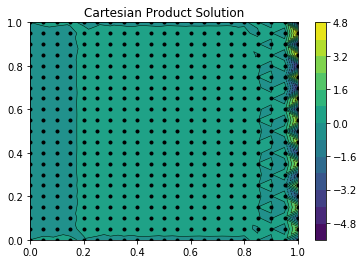

In [5]:
#now find way to plot (we know we have regular grid in this case)
fig,  ax2 = plt.subplots(nrows=1)

ax2.tricontour(global_dof[:,0], global_dof[:,1], u, levels=14, linewidths=0.5, colors='k')
cntr2 = ax2.tricontourf(global_dof[:,0], global_dof[:,1], u, levels=14)#, cmap="RdBu_r")

fig.colorbar(cntr2, ax=ax2)
ax2.plot(global_dof[:,0], global_dof[:,1], 'ko', ms=3)
#ax2.set(xlim=(0, 1), ylim=(0, 1))
ax2.set_title('Cartesian Product Solution')

plt.subplots_adjust(hspace=0.5)
plt.show()

In [6]:
a = np.array([1,2,4,8,16,32,64,128])
print(a[0:2:4])

[1]
